<a href="https://colab.research.google.com/github/JYoung998/Quant-Projects/blob/main/VolatilityForecastEngine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Starting Volatility Forecast Engine...
------------------------------
Parameters:
  Data file: historical_prices.csv (Sample data generated if not found)
  Number of lags for ML: 5
  Rolling window size: 20
  Test set size: 0.2
------------------------------
File not found at historical_prices.csv. Generating sample data.
Data loaded. Shape: (252, 1)
                 Close
Date                  
2023-01-01  100.999830
2023-01-02  101.653757
2023-01-03  101.792568
2023-01-04  102.088113
2023-01-05  103.393934
------------------------------
Log returns computed. Shape: (251, 1)
            Log_Returns
Date                   
2023-01-02     0.006454
2023-01-03     0.001365
2023-01-04     0.002899
2023-01-05     0.012710
2023-01-06    -0.009521
------------------------------
Fitting GARCH(1,1) model...
GARCH model fitted.
GARCH in-sample forecasts generated. Shape: (251,)
Date
2023-01-02    0.00986
2023-01-03    0.00986
2023-01-04    0.00986
2023-01-05    0.00986
2023-01-06    0.00986
Name

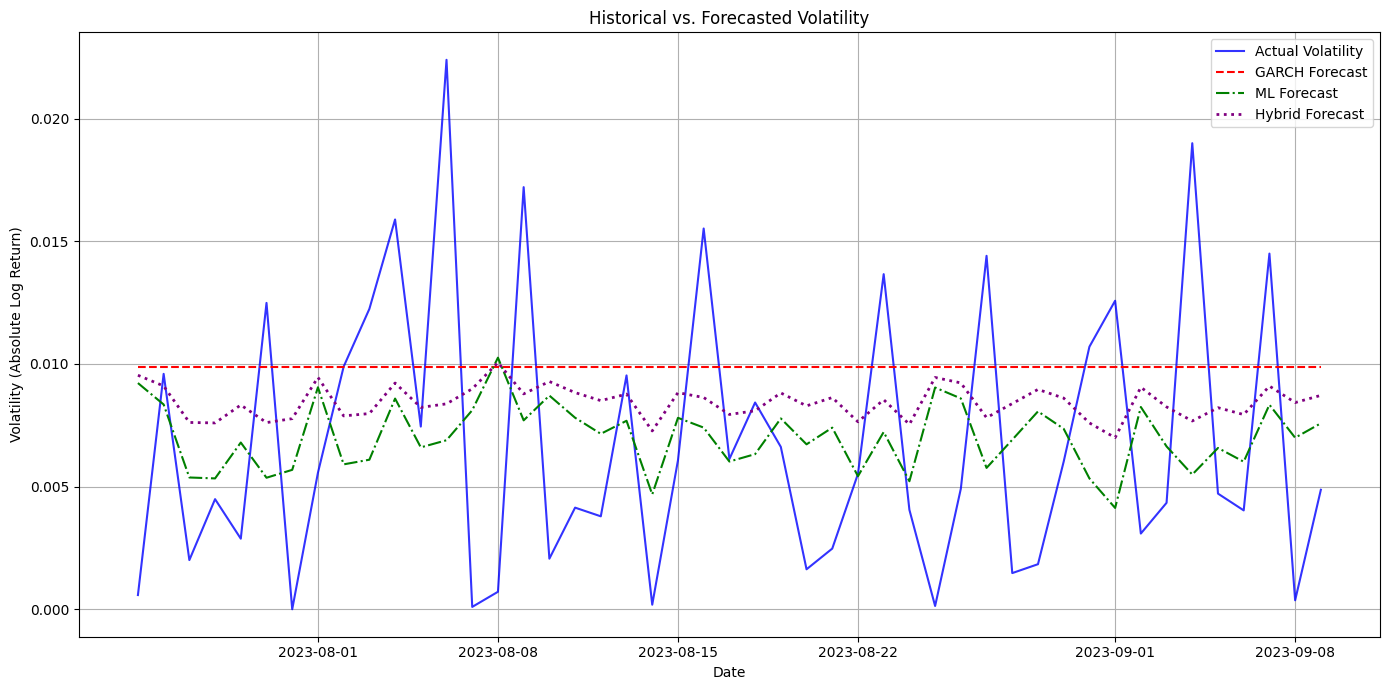

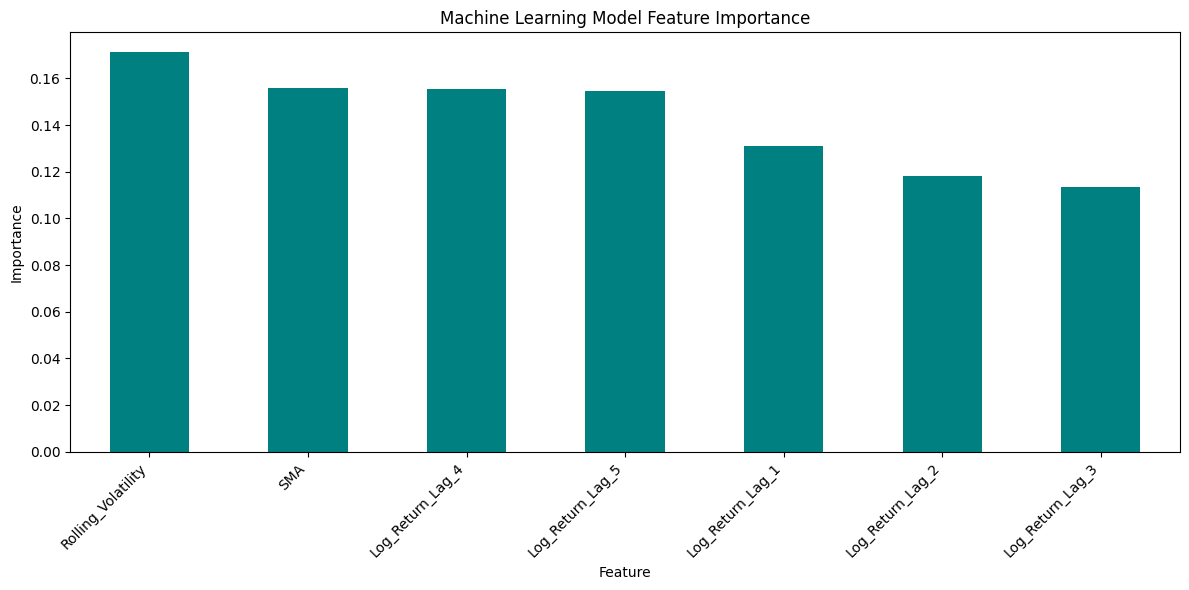

------------------------------
Volatility Forecast Engine execution complete.


In [29]:
"""
Volatility Forecast Engine

This program demonstrates a hybrid approach to forecasting financial market volatility
by combining traditional GARCH modeling with machine learning techniques. It takes
historical price data, computes log returns, fits a GARCH(1,1) model, engineers
features for a machine learning model (Random Forest), trains the ML model to
predict volatility, combines the GARCH and ML forecasts into a hybrid prediction,
evaluates the performance of each model, and visualizes the results along with
ML feature importance.


Optional enhancements (not fully implemented in this version but noted in comments):
- Hyperparameter tuning for the ML model.
- Multi-asset forecasting by looping through multiple datasets.
- More sophisticated feature engineering or alternative technical indicators.
- Different ML models (e.g., Gradient Boosting, LSTM).
- More advanced volatility combination methods (e.g., weighted average based on performance).
- Backtesting framework for robust evaluation.
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from arch import arch_model
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error


def load_or_generate_data(file_path):
    """
    Loads historical price data from a CSV file or generates sample data if the file doesn't exist.

    Args:
        file_path (str): The path to the CSV file.

    Returns:
        pd.DataFrame: A DataFrame containing historical price data with 'Date' and 'Close' columns,
                      indexed by 'Date'.
    """
    if os.path.exists(file_path):
        print(f"Loading data from {file_path}")
        df = pd.read_csv(file_path)
        # Ensure 'Date' column is in datetime format and set as index if it exists
        if 'Date' in df.columns:
            df['Date'] = pd.to_datetime(df['Date'])
            df.set_index('Date', inplace=True)
        elif 'date' in df.columns: # check for lowercase 'date' as well
            df['date'] = pd.to_datetime(df['date'])
            df.set_index('date', inplace=True)
        else:
             raise ValueError("DataFrame must contain a 'Date' or 'date' column.")

        # Ensure 'Close' column exists
        if 'Close' not in df.columns:
             raise ValueError("DataFrame must contain a 'Close' column.")

        return df[['Close']] # Return only the 'Close' column for consistency
    else:
        print(f"File not found at {file_path}. Generating sample data.")
        # Generate sample data
        dates = pd.date_range(start='2023-01-01', periods=252, freq='D') # Simulate a year of daily data
        # Simulate price movements with a trend and some noise
        # Using a random walk with drift for more realistic price series
        initial_price = 100
        returns = np.random.randn(252) * 0.01 # Daily returns with std deviation of 1%
        price = initial_price * np.exp(np.log(1 + returns).cumsum())
        df = pd.DataFrame({'Date': dates, 'Close': price})
        df.set_index('Date', inplace=True)
        return df[['Close']] # Return only the 'Close' column


def compute_log_returns(df):
    """
    Computes the daily log returns from a DataFrame with a 'Close' column.

    Args:
        df (pd.DataFrame): DataFrame with a 'Close' column, indexed by date.

    Returns:
        pd.DataFrame: DataFrame with a 'Log_Returns' column, indexed by date.
                      The first row (NaN after differencing) is dropped.
    """
    if 'Close' not in df.columns:
        raise ValueError("DataFrame must contain a 'Close' column.")

    # Compute log returns: ln(P_t / P_{t-1})
    df['Log_Returns'] = np.log(df['Close'] / df['Close'].shift(1))

    # Handle missing values (the first row will be NaN after shift and log)
    # Dropping the first row is standard practice for differenced series
    df.dropna(subset=['Log_Returns'], inplace=True)

    return df[['Log_Returns']]


def fit_garch_model(log_returns_df):
    """
    Fits a GARCH(1,1) model to log returns and generates in-sample volatility forecasts.

    Args:
        log_returns_df (pd.DataFrame): DataFrame containing log returns with a 'Log_Returns' column,
                                       indexed by date.

    Returns:
        tuple: A tuple containing the fitted GARCH model object and a pandas Series
               of in-sample conditional volatility forecasts (standard deviation).
    """
    if 'Log_Returns' not in log_returns_df.columns:
         raise ValueError("DataFrame must contain a 'Log_Returns' column.")

    # Fit GARCH(1,1) model
    # The data should be a Series or numpy array for arch_model
    # Scaling returns by 100 is a common practice for numerical stability in GARCH models
    returns_series = log_returns_df['Log_Returns'] * 100

    # Specify the GARCH model: mean='zero' as returns are typically centered around zero,
    # vol='Garch' for GARCH process, p=1, q=1 for GARCH(1,1)
    model = arch_model(returns_series, mean='zero', vol='Garch', p=1, q=1)
    fitted_model = model.fit(disp='off') # disp='off' to suppress optimization output

    # Generate in-sample conditional volatility forecasts (standard deviation)
    # Unscale the volatility back to the original return scale by dividing by 100
    in_sample_volatility = fitted_model.conditional_volatility / 100

    # Return the conditional volatility as a pandas Series with the correct index
    in_sample_volatility_series = pd.Series(in_sample_volatility, index=log_returns_df.index, name='cond_vol')

    return fitted_model, in_sample_volatility_series


def create_ml_features(log_returns_df, historical_data, num_lags=5, rolling_window=20):
    """
    Generates features for the machine learning model from log returns and historical prices.

    Args:
        log_returns_df (pd.DataFrame): DataFrame containing log returns with a 'Log_Returns' column,
                                       indexed by date.
        historical_data (pd.DataFrame): DataFrame containing historical price data with a 'Close' column,
                                        indexed by date.
        num_lags (int): The number of lagged absolute log returns to include as features.
        rolling_window (int): The window size for computing rolling historical volatility
                              and Simple Moving Average (SMA).

    Returns:
        pd.DataFrame: DataFrame with added feature columns, including lagged returns,
                      rolling volatility, and SMA, aligned by date. Contains 'Log_Returns'
                      which will be used to derive the target variable.
    """
    # Ensure dataframes are aligned by index (Date)
    # We'll merge log returns and historical data first
    # Use absolute log returns for features, as magnitude is more relevant for volatility prediction
    features_df = log_returns_df.copy()
    features_df['Absolute_Log_Returns'] = features_df['Log_Returns'].abs()


    # Add historical prices for technical indicators like SMA
    # Using inner join to ensure only dates present in both dataframes are kept
    features_df = features_df.join(historical_data[['Close']], how='inner')


    # 1. Compute lagged absolute log returns as features
    for i in range(1, num_lags + 1):
        features_df[f'Log_Return_Lag_{i}'] = features_df['Absolute_Log_Returns'].shift(i)

    # 2. Compute rolling historical volatility (using standard deviation of log returns)
    # Calculated on the original log returns series before taking absolute values for features
    features_df['Rolling_Volatility'] = log_returns_df['Log_Returns'].rolling(window=rolling_window).std()

    # 3. Compute Simple Moving Average (SMA) of the closing price
    features_df['SMA'] = features_df['Close'].rolling(window=rolling_window).mean()

    # Drop the original 'Absolute_Log_Returns' and 'Close' columns as they are not direct features
    # 'Log_Returns' (the original) is kept as it's used to derive the target variable later
    features_df.drop(columns=['Absolute_Log_Returns', 'Close'], inplace=True)


    # Handle missing values created by lagging and rolling calculations
    # Drop rows with NaN values, as these initial rows won't have full feature sets
    features_df.dropna(inplace=True)

    return features_df


def train_ml_model(X_train, y_train):
    """
    Trains a Random Forest Regressor model to predict volatility.

    Args:
        X_train (pd.DataFrame): Training features.
        y_train (pd.Series): Training target variable (e.g., absolute log returns).

    Returns:
        sklearn.ensemble.RandomForestRegressor: The trained scikit-learn model object.
    """
    # Instantiate a Machine Learning Regressor model (Random Forest Regressor)
    # n_estimators: number of trees in the forest
    # random_state: for reproducibility
    # n_jobs: use all available cores
    ml_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)

    # Train the model
    print("Training ML model...")
    ml_model.fit(X_train, y_train)
    print("ML model training complete.")

    return ml_model


def create_hybrid_forecast(garch_forecasts, ml_predictions):
    """
    Combines GARCH volatility forecasts and ML predictions to produce a hybrid forecast.

    Args:
        garch_forecasts (pd.Series): Time series of GARCH volatility forecasts, indexed by date.
        ml_predictions (pd.Series): Time series of ML volatility predictions, indexed by date.

    Returns:
        pd.Series: A time series of hybrid volatility forecasts, indexed by date.
    """
    # Ensure forecasts are pandas Series and have names for clarity
    if not isinstance(garch_forecasts, pd.Series):
         raise TypeError("garch_forecasts must be a pandas Series.")
    if not isinstance(ml_predictions, pd.Series):
         raise TypeError("ml_predictions must be a pandas Series.")

    garch_forecasts = garch_forecasts.rename('GARCH_Forecast')
    ml_predictions = ml_predictions.rename('ML_Forecast')


    # Align the GARCH and ML forecasts based on their indices
    # Use inner join to keep only dates present in both forecasts
    combined_forecasts = pd.concat([garch_forecasts, ml_predictions], axis=1, join='inner')

    # Implement a simple combination method (e.g., simple average)
    # More advanced methods could be implemented here (e.g., weighted average)
    combined_forecasts['Hybrid_Forecast'] = combined_forecasts.mean(axis=1)


    # Return the hybrid forecast series
    return combined_forecasts['Hybrid_Forecast']


def evaluate_model(actual_volatility, predicted_volatility):
    """
    Evaluates model performance using Mean Absolute Error (MAE) and Root Mean Squared Error (RMSE).

    Args:
        actual_volatility (pd.Series): Time series of actual volatility values.
        predicted_volatility (pd.Series): Time series of predicted volatility values.

    Returns:
        tuple: A tuple containing the MAE and RMSE.
    """
    # Ensure the actual and predicted volatility series are aligned by index
    # This is important if they cover different date ranges or have different frequencies
    # Use inner join to evaluate only on the dates present in both series
    aligned_data = pd.concat([actual_volatility, predicted_volatility], axis=1, join='inner')

    # Check if there's any data left after joining
    if aligned_data.empty:
        print("Warning: No overlapping dates between actual and predicted volatility for evaluation.")
        return np.nan, np.nan # Return NaN if no data to evaluate

    aligned_actual = aligned_data.iloc[:, 0]
    aligned_predicted = aligned_data.iloc[:, 1]


    # Calculate MAE
    mae = mean_absolute_error(aligned_actual, aligned_predicted)

    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(aligned_actual, aligned_predicted))

    return mae, rmse


def plot_volatility_forecasts(actual_volatility, garch_forecasts, ml_forecasts, hybrid_forecasts):
    """
    Plots historical actual volatility against GARCH, ML, and hybrid forecasts.

    Args:
        actual_volatility (pd.Series): Time series of actual volatility values (e.g., absolute log returns).
        garch_forecasts (pd.Series): Time series of GARCH volatility forecasts.
        ml_forecasts (pd.Series): Time series of ML volatility forecasts.
        hybrid_forecasts (pd.Series): Time series of hybrid volatility forecasts.
    """
    plt.figure(figsize=(14, 7)) # Set figure size for better readability

    # Plot actual volatility
    plt.plot(actual_volatility.index, actual_volatility, label='Actual Volatility', alpha=0.8, color='blue')

    # Plot forecasts. Align them to the actual volatility index to ensure they cover the same period.
    # This is crucial when plotting test period forecasts against actual test volatility.
    aligned_garch = garch_forecasts.reindex(actual_volatility.index)
    aligned_ml = ml_forecasts.reindex(actual_volatility.index)
    aligned_hybrid = hybrid_forecasts.reindex(actual_volatility.index)

    plt.plot(aligned_garch.index, aligned_garch, label='GARCH Forecast', linestyle='--', color='red')
    plt.plot(aligned_ml.index, aligned_ml, label='ML Forecast', linestyle='-.', color='green')
    plt.plot(aligned_hybrid.index, aligned_hybrid, label='Hybrid Forecast', linestyle=':', color='purple', linewidth=2)

    plt.title('Historical vs. Forecasted Volatility')
    plt.xlabel('Date')
    plt.ylabel('Volatility (Absolute Log Return)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout() # Adjust layout to prevent labels overlapping
    plt.show()


def plot_feature_importance(model, feature_names):
    """
    Plots the feature importance of a trained machine learning model.

    Args:
        model: Trained scikit-learn model with a 'feature_importances_' attribute
               (e.g., RandomForestRegressor, GradientBoostingRegressor).
        feature_names (list or pd.Index): List of feature names corresponding to the model's input features.
    """
    # Check if the model has the feature_importances_ attribute
    if not hasattr(model, 'feature_importances_'):
        print("Error: Model does not have feature_importances_ attribute.")
        print("Feature importance plotting is only supported for models like RandomForest or Gradient Boosting.")
        return

    importances = model.feature_importances_
    # Create a pandas Series for easier sorting and plotting
    feature_importances = pd.Series(importances, index=feature_names)

    # Sort features by importance in descending order
    sorted_importances = feature_importances.sort_values(ascending=False)

    plt.figure(figsize=(12, 6)) # Set figure size
    # Create a bar plot of feature importances
    sorted_importances.plot(kind='bar', color='teal')
    plt.title('Machine Learning Model Feature Importance')
    plt.xlabel('Feature')
    plt.ylabel('Importance')
    plt.xticks(rotation=45, ha='right') # Rotate labels for better readability
    plt.tight_layout() # Adjust layout to prevent labels overlapping
    plt.show()


# --- Main Execution Block ---
if __name__ == "__main__":
    # 1. Welcome message and setup
    print("Starting Volatility Forecast Engine...")
    print("-" * 30)

    # 2. Define sample parameters
    # Path to your historical price data CSV file. If not found, sample data will be generated.
    data_file_path = 'historical_prices.csv'
    num_lags = 5 # Number of past log returns to use as features
    rolling_window = 20 # Window size for rolling volatility and SMA
    test_size = 0.2 # Proportion of data to use for the test set (for ML and evaluation)

    # Optional: Parameters for multi-asset forecasting
    # Example: A list of file paths if you had data for multiple assets
    # asset_files = ['asset_a.csv', 'asset_b.csv']
    # You would loop through this list in the main block to process each asset

    # Optional: Hyperparameter tuning parameters for the ML model
    # Example: A dictionary of hyperparameters to search over
    # ml_param_grid = {
    #     'n_estimators': [100, 200, 500],
    #     'max_depth': [None, 10, 20, 30]
    # }
    # You would use GridSearchCV or RandomizedSearchCV from sklearn.model_selection
    # to find the best hyperparameters for the ML model.

    print(f"Parameters:")
    print(f"  Data file: {data_file_path} (Sample data generated if not found)")
    print(f"  Number of lags for ML: {num_lags}")
    print(f"  Rolling window size: {rolling_window}")
    print(f"  Test set size: {test_size}")
    print("-" * 30)


    # Optional: Loop for multi-asset forecasting
    # for asset_file in asset_files:
    #     print(f"\nProcessing asset data from: {asset_file}")
    #     data_file_path = asset_file # Update the file path for the current asset

    # 3. Load or generate data
    try:
        historical_data = load_or_generate_data(data_file_path)
        print(f"Data loaded. Shape: {historical_data.shape}")
        print(historical_data.head())
        print("-" * 30)
    except ValueError as e:
        print(f"Error loading data: {e}")
        exit() # Exit if data loading fails


    # 4. Compute log returns
    log_returns_df = compute_log_returns(historical_data.copy())
    print(f"Log returns computed. Shape: {log_returns_df.shape}")
    print(log_returns_df.head())
    print("-" * 30)

    # 5. Fit GARCH model on the entire log returns data and generate in-sample forecasts
    # GARCH is typically fitted on the full historical data to capture overall volatility dynamics
    print("Fitting GARCH(1,1) model...")
    try:
        garch_model_fitted, garch_volatility_forecasts = fit_garch_model(log_returns_df.copy())
        print("GARCH model fitted.")
        # print("GARCH Model Summary:")
        # print(garch_model_fitted.summary()) # Uncomment to see full summary
        print(f"GARCH in-sample forecasts generated. Shape: {garch_volatility_forecasts.shape}")
        print(garch_volatility_forecasts.head())
        print("-" * 30)
    except Exception as e:
        print(f"Error fitting GARCH model: {e}")
        # Continue with ML model if GARCH fails, but evaluation will be limited
        garch_volatility_forecasts = None # Set to None if fitting failed


    # 6. Create ML features
    # Features are created on the entire dataset first before splitting
    print("Creating ML features...")
    try:
        ml_features_df = create_ml_features(log_returns_df.copy(), historical_data.copy(), num_lags, rolling_window)
        print(f"ML features created. Shape: {ml_features_df.shape}")
        print(ml_features_df.head())
        print("-" * 30)
    except ValueError as e:
        print(f"Error creating ML features: {e}")
        exit() # Exit if feature creation fails

    # Define features (X) and target (y) for the ML model from the cleaned features_df
    # The target (y) is the absolute log return for the current period,
    # predicted using lagged features and indicators from previous periods.
    X_ml = ml_features_df.drop(columns=['Log_Returns']) # Features for ML
    y_ml = ml_features_df['Log_Returns'].abs() # Target for ML (absolute log returns)


    # Determine the split point based on test_size, applied to the ML features DataFrame
    # This ensures the split is consistent across X and y after NaNs from feature creation are handled
    split_index_ml = int(len(ml_features_df) * (1 - test_size))
    print(f"Splitting data for ML: Train size = {split_index_ml}, Test size = {len(ml_features_df) - split_index_ml}")


    # Split features and target for ML based on this calculated split point
    X_train_ml = X_ml.iloc[:split_index_ml]
    X_test_ml = X_ml.iloc[split_index_ml:]
    y_train_ml = y_ml.iloc[:split_index_ml]
    y_test_ml = y_ml.iloc[split_index_ml:]

    print(f"X_train_ml shape: {X_train_ml.shape}, y_train_ml shape: {y_train_ml.shape}")
    print(f"X_test_ml shape: {X_test_ml.shape}, y_test_ml shape: {y_test_ml.shape}")
    print("-" * 30)


    # Optional: Hyperparameter Tuning for ML model
    # if 'ml_param_grid' in locals():
    #     from sklearn.model_selection import GridSearchCV
    #     print("Performing hyperparameter tuning for ML model...")
    #     grid_search = GridSearchCV(RandomForestRegressor(random_state=42, n_jobs=-1),
    #                                ml_param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
    #     grid_search.fit(X_train_ml, y_train_ml)
    #     ml_model = grid_search.best_estimator_
    #     print(f"Best ML model parameters: {grid_search.best_params_}")
    #     print("-" * 30)
    # else:
    # 7. Train ML model using the determined split
    ml_model = train_ml_model(X_train_ml, y_train_ml)


    # Make predictions on the test data using the trained ML model
    y_pred_ml = ml_model.predict(X_test_ml)

    # Convert ML predictions numpy array to a pandas Series with the correct index (from y_test_ml)
    # This is essential for alignment in evaluation and hybrid forecasting
    y_pred_ml_series = pd.Series(y_pred_ml, index=y_test_ml.index, name='ML_Forecast')

    print(f"ML test predictions generated. Shape: {y_pred_ml_series.shape}")
    print(y_pred_ml_series.head())
    print("-" * 30)


    # Filter GARCH forecasts to match the date index of the ML test set
    # This aligns the GARCH forecasts for direct comparison and hybrid combination
    # with the ML model's output.
    if garch_volatility_forecasts is not None:
        garch_forecasts_for_hybrid = garch_volatility_forecasts.reindex(y_test_ml.index).dropna()
        # Reindex can introduce NaNs if GARCH forecasts don't exist for test dates, drop them
        if garch_forecasts_for_hybrid.empty:
            print("Warning: No overlapping dates between GARCH forecasts and ML test set.")
            garch_forecasts_for_hybrid = None # Cannot create hybrid or evaluate GARCH/Hybrid
    else:
        garch_forecasts_for_hybrid = None


    # 8. Create hybrid forecast
    # Hybrid forecast requires both GARCH and ML forecasts for the same period
    hybrid_volatility_forecast = None # Initialize hybrid forecast
    if garch_forecasts_for_hybrid is not None:
        print("Creating hybrid forecast...")
        try:
            hybrid_volatility_forecast = create_hybrid_forecast(garch_forecasts_for_hybrid, y_pred_ml_series.reindex(garch_forecasts_for_hybrid.index).dropna())
            # Reindex ML predictions to match GARCH test dates before creating hybrid
            print(f"Hybrid forecast created. Shape: {hybrid_volatility_forecast.shape}")
            print(hybrid_volatility_forecast.head())
            print("-" * 30)
        except Exception as e:
             print(f"Error creating hybrid forecast: {e}")
    else:
        print("Skipping hybrid forecast creation due to missing GARCH forecasts for test period.")


    # --- Model Evaluation ---
    print("Evaluating model performance on the test set:")

    # 9. Evaluate GARCH model on the test set
    if garch_forecasts_for_hybrid is not None:
        garch_mae, garch_rmse = evaluate_model(y_test_ml, garch_forecasts_for_hybrid)
        print(f"  GARCH Model Performance: MAE={garch_mae:.6f}, RMSE={garch_rmse:.6f}")
    else:
         print("  GARCH Model Performance: Not evaluated (no GARCH forecasts for test period).")


    # 10. Evaluate ML model on the test set
    ml_mae, ml_rmse = evaluate_model(y_test_ml, y_pred_ml_series)
    print(f"  ML Model Performance: MAE={ml_mae:.6f}, RMSE={ml_rmse:.6f}")


    # 11. Evaluate hybrid model on the test set
    if hybrid_volatility_forecast is not None:
        hybrid_mae, hybrid_rmse = evaluate_model(y_test_ml, hybrid_volatility_forecast)
        print(f"  Hybrid Model Performance: MAE={hybrid_mae:.6f}, RMSE={hybrid_rmse:.6f}")
    else:
        print("  Hybrid Model Performance: Not evaluated (hybrid forecast not created).")
    print("-" * 30)


    # --- Visualization ---
    print("Generating plots...")

    # 12. Plot volatility forecasts for the test period
    # Pass the test set actual volatility and the aligned forecasts
    if garch_forecasts_for_hybrid is not None and hybrid_volatility_forecast is not None:
         # Ensure ML predictions are also aligned to the hybrid forecast index for plotting consistency
         plot_volatility_forecasts(y_test_ml, garch_forecasts_for_hybrid, y_pred_ml_series, hybrid_volatility_forecast)
    elif garch_forecasts_for_hybrid is not None:
         # Plot GARCH and ML if hybrid is not available
         plot_volatility_forecasts(y_test_ml, garch_forecasts_for_hybrid, y_pred_ml_series, y_pred_ml_series) # Pass ML twice if no hybrid
    else:
        # Plot only ML if GARCH and Hybrid are not available
         plot_volatility_forecasts(y_test_ml, y_pred_ml_series, y_pred_ml_series, y_pred_ml_series) # Pass ML for all forecast slots


    # 13. Plot ML feature importance
    # Use the feature names from the training data used for the ML model
    feature_names = X_train_ml.columns
    plot_feature_importance(ml_model, feature_names)

    print("-" * 30)
    print("Volatility Forecast Engine execution complete.")

    # Optional: Multi-asset forecasting summary (if implemented)
    # if 'asset_files' in locals():
    #     print("\n--- Multi-Asset Forecasting Summary ---")
    #     # You would collect and display results for each asset here
    #     print("Summary of performance for each asset...")